PROGRAMACIÓN DE LA LÓGICA PROGRAMABLE E IMPORTACIÓN DE LIBRERÍAS.

In [ ]:
from pynq import Overlay
base = Overlay("/home/xilinx/jupyter_notebooks/MisCosas/Config/PlantaEnFPGA.bit")

from pynq.lib import AxiGPIO

#Importamos una librería para poder graficar el resultado de la simulación.
import matplotlib.pyplot as plt
import time

DECLARACIÓN DE VARIABLES

In [16]:
#Variables que se emplearán en el programa.
Nbits, ParteEntera, Escalon, Tiempo, Ts = 16, 4, 50.9, 50, 1

FUNCIONES PARA EL TRATAMIENTO DE LOS NÚMEROS

In [17]:
#Esta función convierte a binario el número decimal que se le pase como argumento de entrada. 
#El resultado es una lista donde la posición 0 equivale al LSB. Es decir, está invertido.
def ToBinary(IN):
    B=[]
    #Mientras el número sea mayor que uno se sigue aplicando el algoritmo.
    while(IN>1):
        #Se añade a la lista el resto de la divisón IN/2
        B.append(IN%2)
        #Se actualiza el valor de IN para que sea el cociente de la operación IN/2
        IN=IN//2
        #Se añade a la lista el valor actualizado de IN
        B.append(IN)
        
    #Si la longitud de B es menor a Nbits, se concatenan 0.
    while(len(B)<Nbits):
        B.append(0)
        
    return B

In [10]:
#Esta función obtiene la parte decimal binaria del número decimal en formato decimal introducido. 
#El resultado es una lista donde la posición 0 equivale al MSB.
def ToDecimalBinary(IN):
    B=[]
    #El algoritmo se realiza tantas veces como sea necesario para obtener el número de bits adecuados
    for i in range(0, ParteEntera):
        #Si PM>=0 quiere decir que 2^(-i-1) forma parte del número binario decimal.
        PM=IN-2**(-i-1)
        if(PM>=0): 
            B.append(1)
            #Se actualiza el valor de IN
            IN=PM
        else: B.append(0)
            
    return B

In [5]:
#Esta función invierte la lista que se introduce como argumento de entrada. 
#De esta forma, en la posición 0 de la lista estará el MSB
def InvertBinary(IN):
    B=[]
    for i in range(len(IN)-1, -1, -1):
        B.append(IN[i])
        
    return B

In [6]:
#Esta función calcula el valor entero en formato decimal del número binario (entero) introducido (en formato lista).
def ToDecimalEntero(IN):
    DE=0
    #Se recorre posición a posición la lista, comenzando por la del MSB.
    for i in range(len(IN)-1, -1, -1):
        DE+=(2**i)*IN[i]
        
    return DE

In [7]:
#Esta función calcula el valor decimal en formato decimal del número binario (decimal) introducido (en formato lista).
def ToDecimalFraccional(IN):
    DF=0
    #Se recorre posición a posición la lista, comenzando por la del MSB.
    for i in range(len(IN)-1, -1, -1):
        DF+=(2**(-i-1))*IN[i]
        
    return DF

ACCESO AL BLOQUE AXI GPIO

In [149]:
AXIGPIO=base.ip_dict['axi_gpio_0']
CanalDeSalida=AxiGPIO(AXIGPIO).channel1
#Para evitar tener que trabajar en formato lista, se realizan las siguientes asignaciones
EntradaPlanta=CanalDeSalida[0:16]
Reset=CanalDeSalida[16:17]

CanalDeEntrada=AxiGPIO(AXIGPIO).channel2

# PROGRAMA

In [150]:
#Se activa el Reset
Reset.write(0)
#Se calcula el número decimal equivalente.
BE=InvertBinary(InvertBinary(ToBinary(int(Escalon//1))[0:Nbits-ParteEntera])+ToDecimalBinary(Escalon-Escalon//1))

In [165]:
#Se introduce 0 como valor de entrada y se levanta el Reset de la planta.
EntradaPlanta.write(0)
Reset.write(1)

SIMULACIÓN CON GRÁFICA A TIEMPO NO REAL.

In [166]:
#Se declaran las listas donde se almacenarán el valor de entrada a la planta, la salida de esta y los tiempos.
Input=[]
y=[]
t=[]

#Se realiza una primera sección de duración Inicio segundos, en los que la entrada será 0.
for i in range(Inicio):
    t.append(i)
    Input.append(0)
    y.append(CanalDeEntrada.read())
    time.sleep(Ts)
    
#Después del tiempo inicial, se escribe el valor del escalón y se recogen los parámetros de la planta.
EntradaPlanta.write(ToDecimalEntero(BE))
time.sleep(Ts)
for i in range(Tiempo-Inicio):
    t.append(i+Inicio)
    Input.append(Escalon)
    y.append(CanalDeEntrada.read())
    time.sleep(Ts)

In [153]:
Output=[]
for i in range(len(y)):
    #Pasamos a binario la lectura de la FPGA.
    S=ToBinary(y[i])
    
    #Se realiza la conversión al número decimal correcto. Para ello,
    #en la parte entera eliminamos los bits decimales, del 0 hasta el 8; 
    #y en la parte decimal eliminamos los bits enteros, del 9 hasta el 15.
    Output.append(ToDecimalEntero(S[ParteEntera:Nbits])+ToDecimalFraccional(InvertBinary(S[0:ParteEntera])))

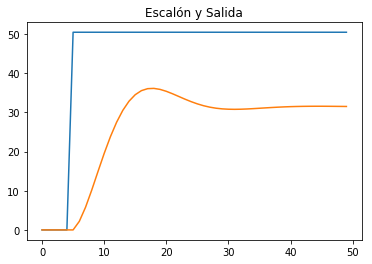

In [154]:
#Se grafica la respuesta de la planta ante el escalón
fig, P1= plt.subplots() 
P1.plot(t, Input, t, Output)
P1.set_title('Escalón y Salida');

SIMULACIÓN CON GRÁFICA A TIEMPO REAL

In [ ]:
Inicio=5
pp=ProgressPlot(plot_names=["Planta de control de nivel"], line_names=["CV", "PV"], x_lim=[0, Tiempo], x_label="Tiempo (s)", y_lim=[0, 100], y_label="%")

y=[]

#Se realiza una primera sección de duración Inicio segundos, en los que la entrada será 0.
for i in range(Inicio):
    pp.update([[0, CanalDeEntrada.read()]])
    time.sleep(Ts)

EntradaPlanta.write(ToDecimalEntero(BE))
time.sleep(Ts)
for i in range(Tiempo-Inicio):
    pp.update([[Escalon, CanalDeEntrada.read()]])
    time.sleep(Ts)